## Après cleanning


In [422]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Analyse du dataset (après cleaning)

## Dataset
- **Taille initiale** : 21 742 lignes et 37 colonnes (avant nettoyage)
- **Unité statistique** : 1 ligne = 1 bien immobilier (une annonce)

## Description des variables (résumé)
Le dataset contient :
- des **variables numériques** (surfaces, pièces, prix, étage…)
- des **variables binaires** (équipements : ascenseur, parking, jardin, piscine…)
- des **variables catégorielles** (type de bien `product`, quartier `neighborhood`, etc.)

## Target
- Target principale : **buy_price**
- Target utilisée pour la régression : **log_buy_price = log1p(buy_price)**
  - Motivation : la distribution de `buy_price` est très asymétrique (présence d’outliers),
    la transformation log réduit l’écart entre les valeurs extrêmes et stabilise la variance.

## Gestion des valeurs manquantes
- **Suppression de colonnes** : toutes les colonnes avec **plus de 40% de valeurs manquantes** sont supprimées.
  - Objectif : éviter d’imputer des variables trop incomplètes et donc peu fiables.

- **Variables binaires (0/1)** : imputation par la **valeur la plus fréquente (mode)**.
  - Hypothèse : lorsqu’une information est manquante, elle correspond le plus souvent au cas majoritaire.
  - Intérêt : conserver un maximum de lignes sans introduire une valeur artificielle.

- **Variable `floor` (étage)** : nettoyage + imputation
  - Conversion de `"bajo"` (rez-de-chaussée) en **0**
  - Conversion en numérique (les valeurs non convertibles deviennent NaN)
  - Imputation des NaN par la **médiane**
  - Motivation : méthode robuste, simple et adaptée à une variable discrète avec quelques valeurs extrêmes.

- **Variables numériques avec faible taux de NA** (ex : `sq_mt_built`, `n_bathrooms`) :
  - Conversion en numérique puis imputation des NA par la **médiane**
  - Motivation : méthode robuste aux outliers, simple et efficace.

## Traitement des incohérences / valeurs extrêmes
- **rent_price** : valeurs négatives considérées comme incohérentes
  - Règle : `rent_price < 0` → NaN, puis imputation par la **médiane**
  - Remarque : si `rent_price` est utilisée en feature, il est préférable d’ajouter un indicateur de manquants pour distinguer les valeurs imputées.

- Les distributions de certaines variables (surfaces, prix) présentent des extrêmes.
  - La transformation log de la target est prioritaire pour stabiliser la régression.
  - Les outliers très manifestes peuvent être traités ensuite (filtrage ou cap) selon les besoins du modèle.

## Variables retenues (features)
Les variables retenues pour la modélisation sont principalement :
- **variables structurelles** : `sq_mt_built`, `n_rooms`, `n_bathrooms`
- **variable de zone** : `neighborhood` (identifiant de quartier)
- **variables d’équipements** : `has_lift`, `has_parking`, `has_pool`, `has_garden`, `has_storage_room`
- **variables complémentaires** : `is_floor_under`

## Hypothèses métier
- **Surface** : plus la surface construite augmente, plus le prix augmente.
- **Pièces / SDB** : plus il y a de chambres et de salles de bain, plus le prix augmente (effet de palier possible).
- **Zone** : le quartier (`neighborhood`) capte une grande partie de la variance des prix (effet non forcément linéaire).
- **Équipements** : ascenseur, parking, piscine, jardin, cave augmentent le prix à caractéristiques égales.


## 1) Imports + load


In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

df = pd.read_csv("houses_madrid_cleaned.csv", encoding="utf-8")
df.head()


,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
0,64.0,60.0,2,1.0,NaN,NaN,3,0.0,471,85000,1328,0,False,1960.0,NaN,NaN,1,0,0.0,1.0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0.0,1.0,0.0,0.0,piso,135
1,70.0,NaN,3,1.0,NaN,NaN,4,0.0,666,129900,1856,1,False,NaN,NaN,NaN,0,1,1.0,1.0,0,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,piso,132
2,94.0,54.0,2,2.0,NaN,NaN,1,0.0,722,144247,1535,0,False,NaN,0.0,1.0,0,1,1.0,1.0,0,0,0,0,1,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,piso,134
3,64.0,NaN,2,1.0,NaN,NaN,bajo,1.0,583,109900,1717,0,False,1955.0,NaN,NaN,0,0,1.0,1.0,0,0,0,0,1,1,0,NaN,0,NaN,NaN,0.0,0.0,1.0,0.0,piso,134
4,108.0,90.0,2,2.0,NaN,NaN,4,0.0,1094,260000,2407,0,False,2003.0,NaN,NaN,1,1,1.0,1.0,0,1,0,0,1,0,1,NaN,1,1.0,0.0,1.0,1.0,1.0,1.0,piso,133


## 2) Data overview
- Dimensions
- Types / valeurs manquantes
- Statistiques descriptives


In [424]:
print("Shape:", df.shape)
df.info()
display(df.describe(include="all").T)


Shape: (21742, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21616 non-null  float64
 1   sq_mt_useful                  8228 non-null   float64
 2   n_rooms                       21742 non-null  int64  
 3   n_bathrooms                   21726 non-null  float64
 4   n_floors                      1437 non-null   float64
 5   sq_mt_allotment               1432 non-null   float64
 6   floor                         19135 non-null  object 
 7   is_floor_under                20572 non-null  float64
 8   rent_price                    21742 non-null  int64  
 9   buy_price                     21742 non-null  int64  
 10  buy_price_by_area             21742 non-null  int64  
 11  is_renewal_needed             21742 non-null  int64  
 12  is_new_development            20750 non-n

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sq_mt_built,21616.0,NaN,NaN,NaN,146.920892,134.181865,13.0,70.0,100.0,162.0,999.0
sq_mt_useful,8228.0,NaN,NaN,NaN,103.458192,88.259192,1.0,59.0,79.0,113.0,998.0
n_rooms,21742.0,NaN,NaN,NaN,3.005749,1.510497,0.0,2.0,3.0,4.0,24.0
n_bathrooms,21726.0,NaN,NaN,NaN,2.091687,1.406992,1.0,1.0,2.0,2.0,16.0
n_floors,1437.0,NaN,NaN,NaN,3.12874,0.907713,1.0,2.0,3.0,4.0,7.0
sq_mt_allotment,1432.0,NaN,NaN,NaN,241.692737,247.484853,1.0,2.0,232.0,354.0,997.0
floor,19135,19,1,4440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_floor_under,20572.0,NaN,NaN,NaN,0.12342,0.328927,0.0,0.0,0.0,0.0,1.0
rent_price,21742.0,NaN,NaN,NaN,-59170.307929,917116.183176,-34590276.0,725.0,1116.0,1687.0,2517.0
buy_price,21742.0,NaN,NaN,NaN,653735.647503,782082.069836,36000.0,198000.0,375000.0,763600.0,8800000.0


## 3) Missing + doublons
On mesure le % de valeurs manquantes et le nombre de doublons stricts (lignes identiques).


In [425]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.to_frame("%_missing").head(30))

dup_count = df.duplicated().sum()
print("Doublons (lignes identiques):", dup_count)


,%_missing
energy_certificate,100.000000
sq_mt_allotment,93.413669
n_floors,93.390672
parking_price,64.497286
is_parking_included_in_price,64.497286
sq_mt_useful,62.156195
built_year,54.010671
is_orientation_north,47.760096
is_orientation_east,47.760096
is_orientation_south,47.760096


Doublons (lignes identiques): 288


## 4) Cleaning (en un bloc)

### Choix appliqués
- **Drop duplicates**
- **Drop colonnes > 40% NA**
- **NA binaires** : Valeur la plus fréquente 
- **floor** : "bajo"→0, conversion numérique, médiane + `floor_missing`
- **rent_price** : négatifs → NaN, puis médiane + `rent_price_missing`
- **Target** : `log_buy_price = log1p(buy_price)`


In [426]:
# 4.1 Drop duplicates
before = len(df)
df = df.drop_duplicates()
print("Doublons supprimés:", before - len(df))

# 4.2 Drop colonnes > 60% NA
threshold = 0.40
cols_to_drop = df.columns[df.isna().mean() > threshold]
df = df.drop(columns=cols_to_drop)
print("Colonnes supprimées (>40% NA):", list(cols_to_drop))

# 4.3 Binaires : 0 + flags missing
bin_cols = ["has_individual_heating","has_central_heating","is_exterior","has_lift","is_floor_under","is_new_development"]

for c in bin_cols:
    df[c] = df[c].fillna(df[c].mode()[0])


# 4.4 floor : nettoyage + médiane + flag
if "floor" in df.columns:
    df["floor"] = df["floor"].replace({"bajo": 0})
    df["floor"] = pd.to_numeric(df["floor"], errors="coerce")
    df["floor"] = df["floor"].fillna(df["floor"].median())

# 4.5 Numériques faible NA : médiane
num_cols = ["sq_mt_built", "n_bathrooms"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].fillna(df[c].median())

# 4.6 rent_price : négatifs -> NaN, puis médiane + flag
if "rent_price" in df.columns:
    df["rent_price"] = pd.to_numeric(df["rent_price"], errors="coerce")
    df.loc[df["rent_price"] < 0, "rent_price"] = np.nan
    df["rent_price"] = df["rent_price"].fillna(df["rent_price"].median())

# 4.7 log target
df["log_buy_price"] = np.log1p(df["buy_price"])

print("Shape après cleaning:", df.shape)


Doublons supprimés: 288
Colonnes supprimées (>40% NA): ['sq_mt_useful', 'n_floors', 'sq_mt_allotment', 'built_year', 'energy_certificate', 'is_parking_included_in_price', 'parking_price', 'is_orientation_north', 'is_orientation_west', 'is_orientation_south', 'is_orientation_east']
Shape après cleaning: (21454, 27)


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_62941/2696625686.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(df[c].mode()[0])


## 5) Contrôle rapide après cleaning
On recheck : shape, missing, stats rapides.


In [427]:
print("Shape:", df.shape)
display((df.isna().mean() * 100).sort_values(ascending=False).head(20).to_frame("%_missing"))
display(df.describe(include="all").T.head(25))


Shape: (21454, 27)


,%_missing
sq_mt_built,0.0
has_lift,0.0
neighborhood,0.0
product,0.0
has_parking,0.0
has_green_zones,0.0
is_accessible,0.0
has_storage_room,0.0
has_balcony,0.0
has_terrace,0.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sq_mt_built,21454.0,NaN,NaN,NaN,147.132656,134.364613,13.0,70.0,100.0,162.0,999.0
n_rooms,21454.0,NaN,NaN,NaN,3.009602,1.514116,0.0,2.0,3.0,4.0,24.0
n_bathrooms,21454.0,NaN,NaN,NaN,2.09588,1.411141,1.0,1.0,2.0,2.0,16.0
floor,21454.0,NaN,NaN,NaN,2.574392,1.904918,0.0,1.0,2.0,4.0,9.0
is_floor_under,21454.0,NaN,NaN,NaN,0.117274,0.321754,0.0,0.0,0.0,0.0,1.0
rent_price,21454.0,NaN,NaN,NaN,1328.399086,551.7653,18.0,901.0,1213.0,1684.5,2517.0
buy_price,21454.0,NaN,NaN,NaN,656313.874243,785766.50642,36000.0,198000.0,375000.0,769750.0,8800000.0
buy_price_by_area,21454.0,NaN,NaN,NaN,4018.488114,1910.516099,447.0,2547.0,3718.0,5000.0,18889.0
is_renewal_needed,21454.0,NaN,NaN,NaN,0.184115,0.387587,0.0,0.0,0.0,0.0,1.0
is_new_development,21454,2,False,19988,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6) EDA courte (10 graphes max)

Objectif :
- vérifier la distribution de la target (brut + log)
- visualiser quelques variables clés
- vérifier 2-3 relations avec le prix


Top 6 variables (corr abs) avec log_buy_price : ['buy_price', 'n_bathrooms', 'sq_mt_built', 'buy_price_by_area', 'n_rooms', 'rent_price']


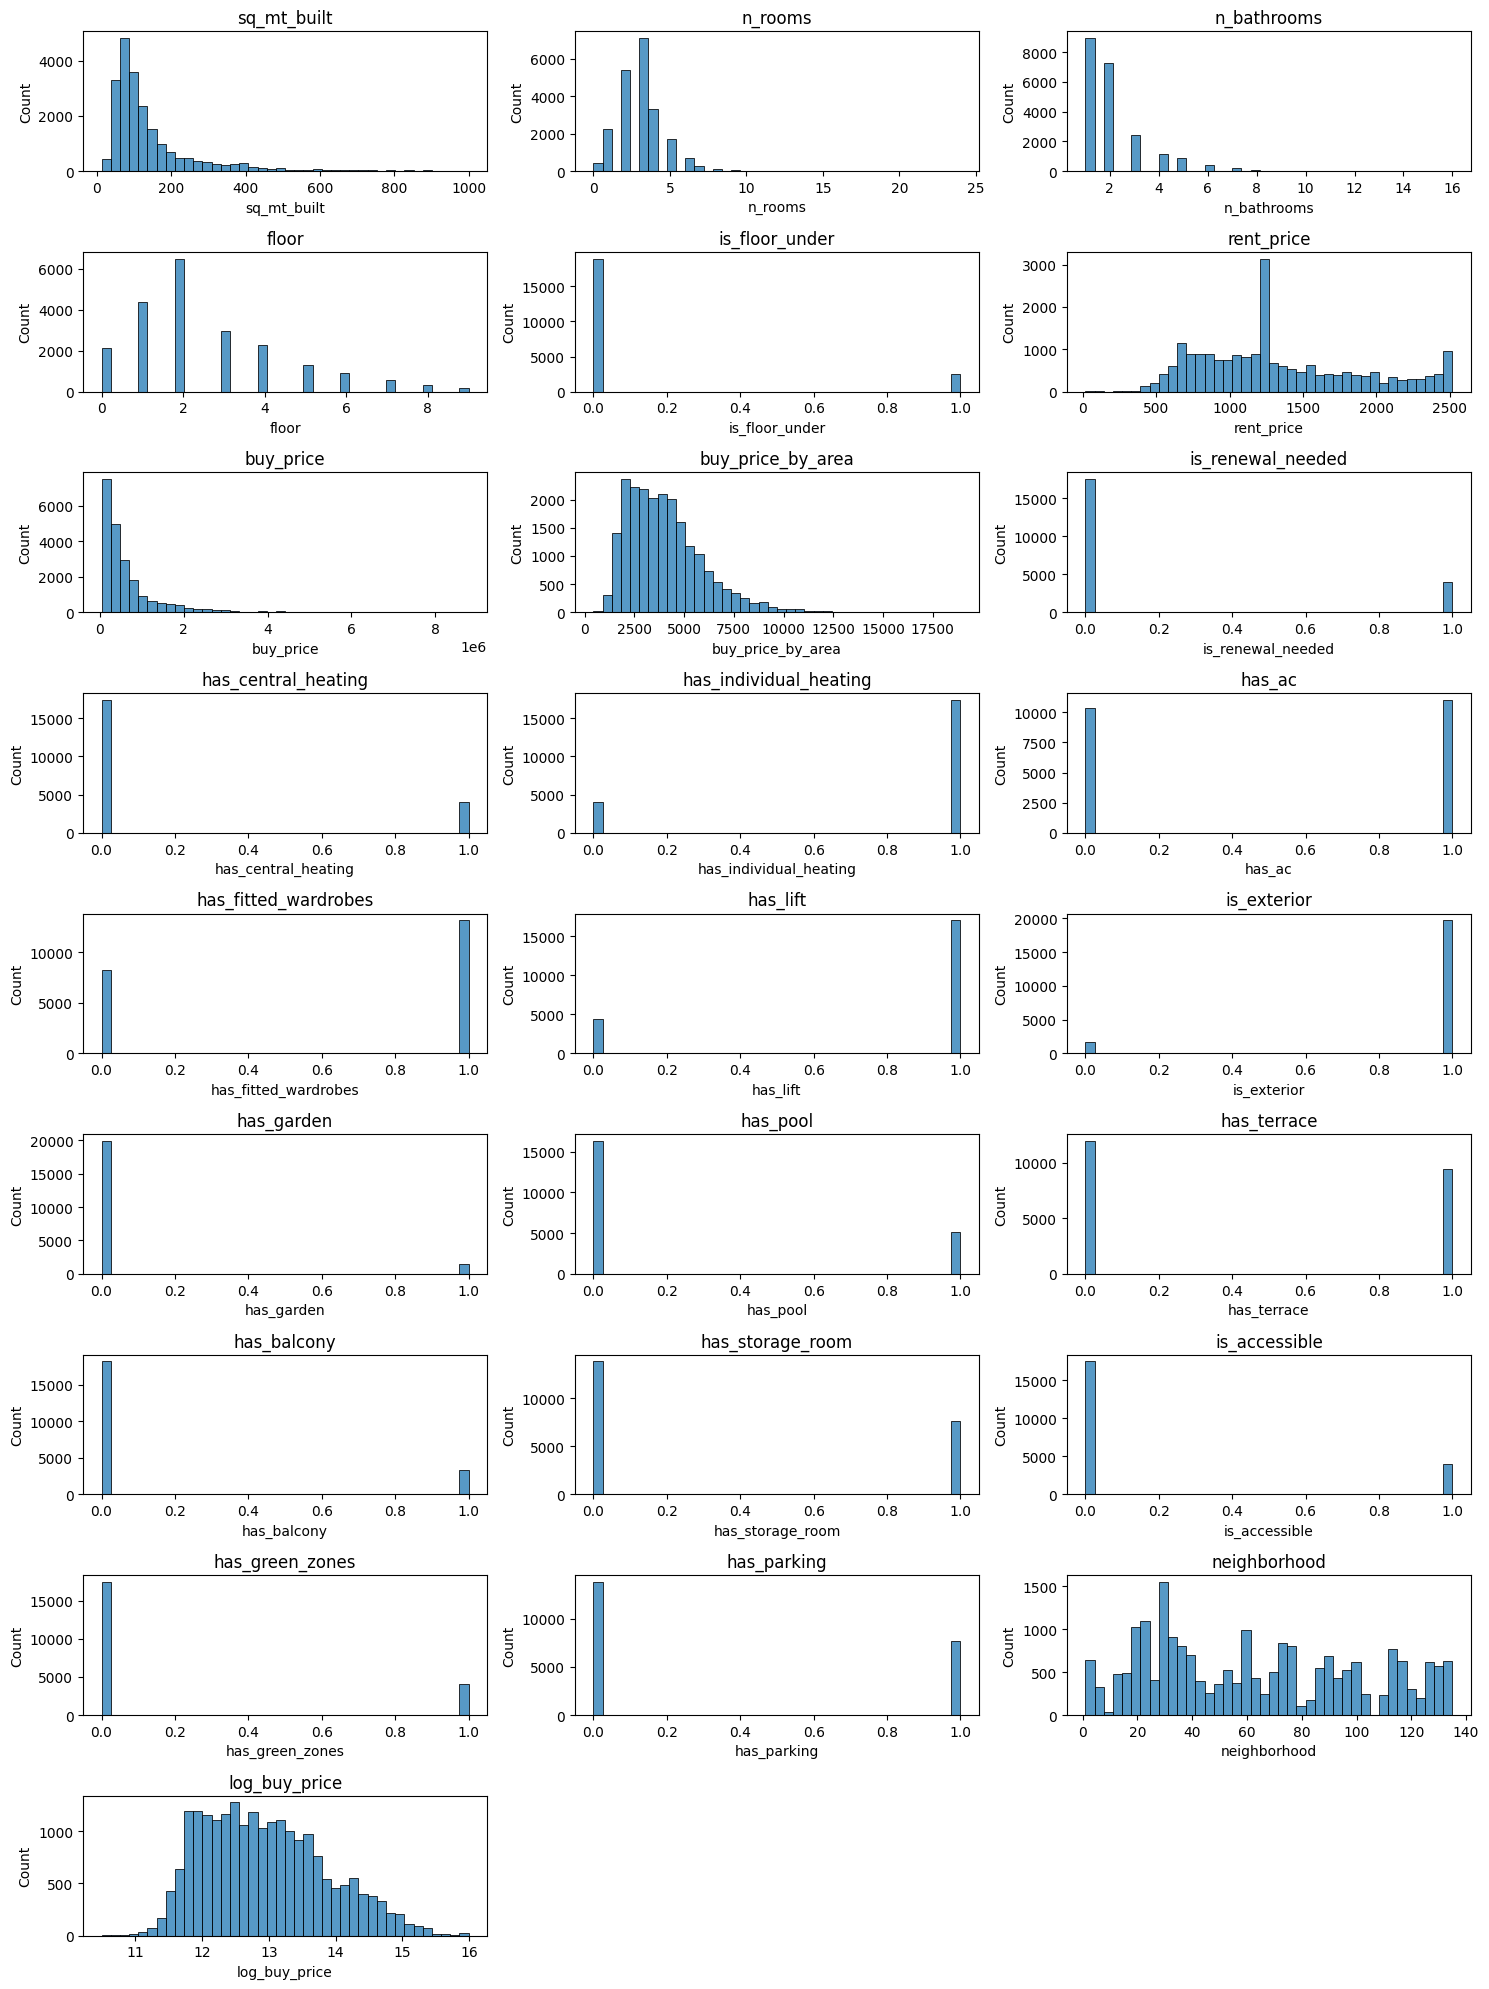

In [428]:
import seaborn as sns

# Définir top_cols (top 6 variables corrélées à log_buy_price)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_target = df[num_cols].corr(numeric_only=True)["log_buy_price"].drop("log_buy_price")
top_cols = corr_target.abs().sort_values(ascending=False).head(6).index.tolist()

print("Top 6 variables (corr abs) avec log_buy_price :", top_cols)
plt.figure(figsize=(15, 20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.histplot(df[col].dropna(), kde=False, bins=40)
    plt.title(col)

plt.tight_layout()
plt.show()

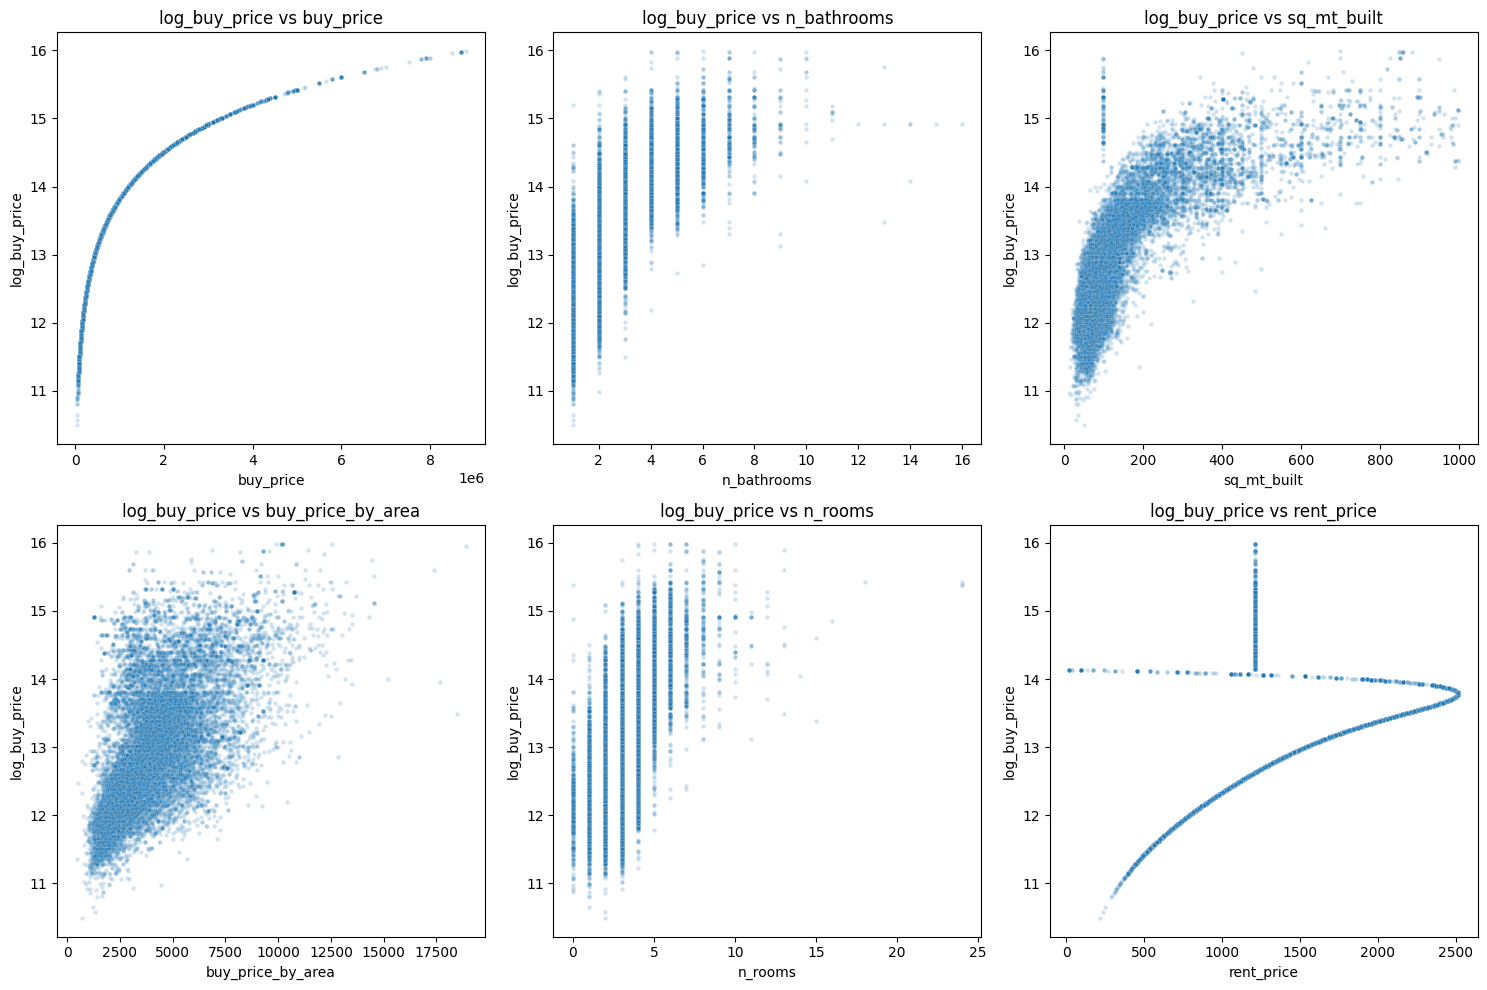

In [429]:


# Assure log_buy_price
if "log_buy_price" not in df.columns and "buy_price" in df.columns:
    df["log_buy_price"] = np.log1p(df["buy_price"])

# Colonnes numériques
num_cols = df.select_dtypes(include=["int64", "float64"]).columns


# 2) Scatter top 6 vs target
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_cols[:6], 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[col], y=df["log_buy_price"], s=10, alpha=0.2)
    plt.title(f"log_buy_price vs {col}")
plt.tight_layout()
plt.show()


## 7) Sélection des features + export

On conserve un set de variables cohérent pour la régression :
- target : `log_buy_price`
- features : surfaces, pièces, prix/m², quartier, équipements
- export d’un CSV “prêt pour modèle”


In [430]:
features = [
    "log_buy_price",
    "sq_mt_built", "n_rooms", "n_bathrooms",
    "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room",
    "is_floor_under",
    "floor"
]

# garder uniquement celles qui existent
features = [c for c in features if c in df.columns]

df_model = df[features].copy()



## 8) Heatmap de corrélation

Objectif : visualiser les corrélations entre les variables numériques retenues (et la target `log_buy_price`).

- Une corrélation proche de **+1** : variables évoluent ensemble
- Proche de **-1** : relation inverse
- Proche de **0** : peu de relation linéaire

⚠️ Attention : corrélation ≠ causalité.  
On s’en sert surtout pour repérer :
- variables très liées (multicolinéarité possible)
- variables fortement liées à la target


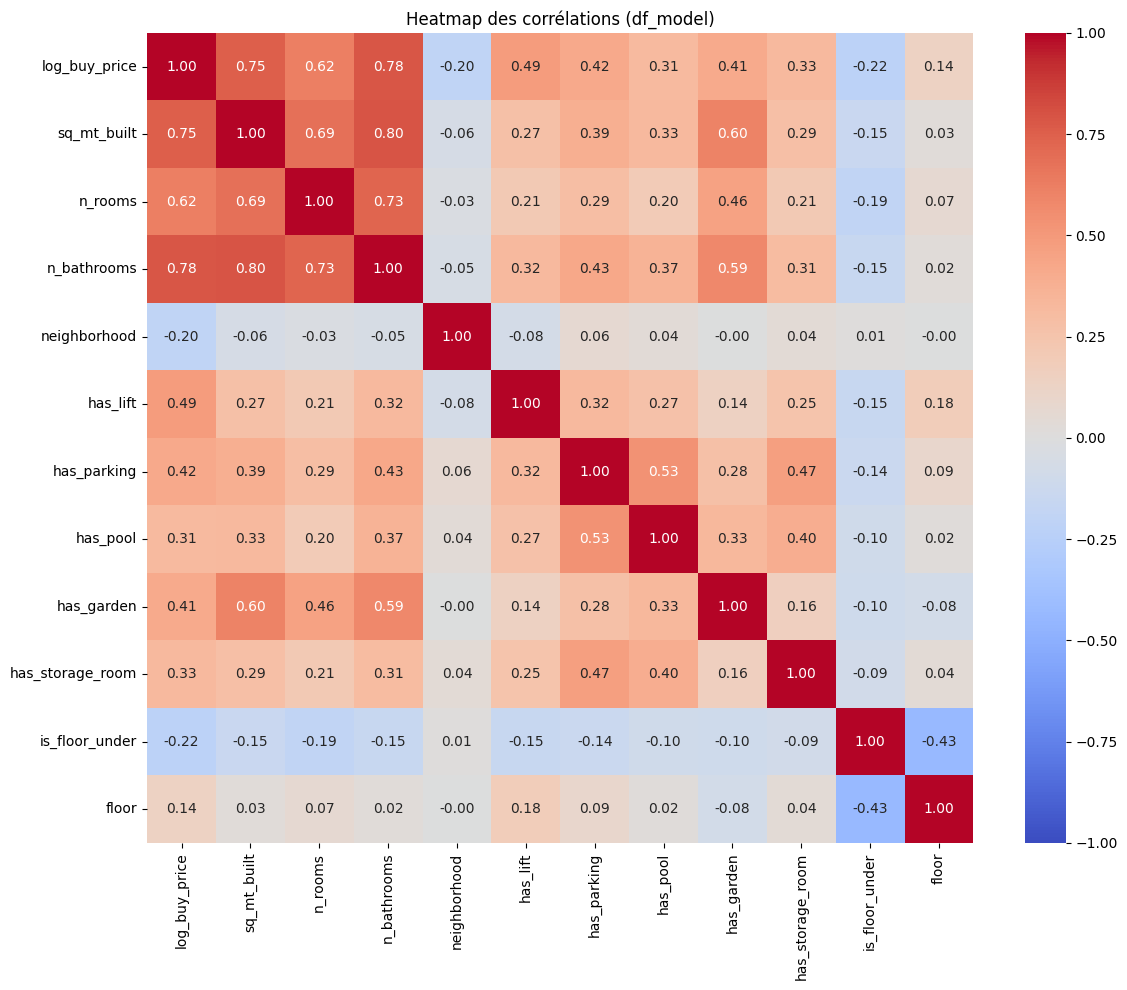

In [431]:
corr = df_model.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Heatmap des corrélations (df_model)")
plt.tight_layout()
plt.show()

In [432]:
df_model = df_model.drop(columns=["floor"])

La target buy_price est très asymétrique (outliers importants). La transformation log_buy_price rend la distribution plus proche d’une forme exploitable et stabilise la variance.

sq_mt_built et n_bathrooms montrent la relation la plus forte avec le prix (corr ≈ 0.75–0.78) et une tendance positive claire sur les scatterplots.

n_rooms est également corrélé mais redondant avec la surface et les salles de bain (multicolinéarité), ce qui peut rendre les coefficients instables en régression linéaire.

Les équipements (has_parking, has_garden, has_storage_room, has_pool, has_lift) apportent un signal complémentaire modéré.

rent_price présente un artefact d’imputation (valeurs regroupées sur une médiane), donc la variable n’est pas retenue (ou doit être utilisée avec un indicateur rent_price_missing).

neighborhood est conservé mais la corrélation linéaire faible est attendue car il s’agit d’un identifiant : l’effet quartier est plutôt non-linéaire/catégoriel.

floor a un signal faible (corr ≈ 0.14) et redondant avec is_floor_under, donc il est retiré dans une version simplifiée des features.

## 10) Export du dataset final

On exporte le dataset de features prêt à être utilisé par les modèles de régression.


In [433]:
df_model.to_csv("houses_madrid_eda_features.csv", index=False)

print("Export OK -> houses_madrid_eda_features.csv")
print("Shape df_model:", df_model.shape)
display(df_model.describe(include="all").T)

Export OK -> houses_madrid_eda_features.csv
Shape df_model: (21454, 11)


,count,mean,std,min,25%,50%,75%,max
log_buy_price,21454.0,12.935101,0.915313,10.491302,12.196027,12.834684,13.553822,15.990262
sq_mt_built,21454.0,147.132656,134.364613,13.000000,70.000000,100.000000,162.000000,999.000000
n_rooms,21454.0,3.009602,1.514116,0.000000,2.000000,3.000000,4.000000,24.000000
n_bathrooms,21454.0,2.095880,1.411141,1.000000,1.000000,2.000000,2.000000,16.000000
neighborhood,21454.0,62.918710,38.288124,1.000000,30.000000,59.000000,94.000000,135.000000
has_lift,21454.0,0.794863,0.403811,0.000000,1.000000,1.000000,1.000000,1.000000
has_parking,21454.0,0.356297,0.478916,0.000000,0.000000,0.000000,1.000000,1.000000
has_pool,21454.0,0.239489,0.426782,0.000000,0.000000,0.000000,0.000000,1.000000
has_garden,21454.0,0.072387,0.259134,0.000000,0.000000,0.000000,0.000000,1.000000
has_storage_room,21454.0,0.355272,0.478607,0.000000,0.000000,0.000000,1.000000,1.000000
